## In this Regression Example we will look at the basic operations of PyTorch in building a model manually ##

The same aplies for classification problems with one or two things being different (like loss function, etc,.)

#### We are going to study the basic PyTorch operations in this notebook in a step-by-step manner as follows:

1. We shall generate some random data and create a train and test set using the basic numpy library.

2. We will then create a linear regression model using some PyTorch operations but in a very manual way (like you did with the gradient descent exercise).

3. Then we will partially automate the model building process using more PyTorch operations.

4. Finally, we will build the same model using all PyTorch operations.

Through this process you will get a very good a good grasp of the PyTorch basics.

In [1]:
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns

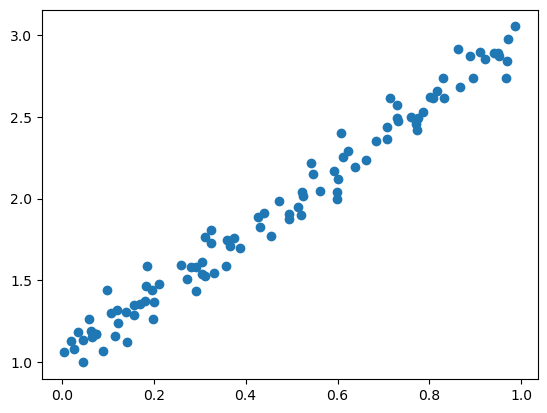

In [2]:
# Data Generation
np.random.seed(42)
x = np.random.rand(100, 1)
y = 1 + 2 * x + .1 * np.random.randn(100, 1)

# Shuffles the indices
idx = np.arange(100)
np.random.shuffle(idx)

# Uses first 80 random indices for train
train_idx = idx[:80]
# Uses the remaining indices for validation
val_idx = idx[80:]

# Generates train and validation sets
x_train, y_train = x[train_idx], y[train_idx]
x_val, y_val = x[val_idx], y[val_idx]
plt.scatter(x,y)
plt.show()

In [3]:
import torch

# We want to take advantage of Nvidia's GPU processing if a Nvidia GPU is available on the machine
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Our data was in Numpy arrays, but we need to transform them into PyTorch's Tensors
# and then we send them to the chosen device
x_train_tensor = torch.from_numpy(x_train).float().to(device)
y_train_tensor = torch.from_numpy(y_train).float().to(device)

# Here we can see the difference - notice that .type() is more useful
# since it also tells us WHERE the tensor is (device)
# torch.FloatTensor — a CPU tensor in this case.
# else, torch.cuda.FloatTensor — a GPU tensor.

print(f"Original data type:{type(x_train)}\nArray converted to tensor:{type(x_train_tensor)}\nIncluding type and location of data:{x_train_tensor.type()}")

Original data type:<class 'numpy.ndarray'>
Array converted to tensor:<class 'torch.Tensor'>
Including type and location of data:torch.FloatTensor


In [4]:
# FIRST
# Initializes parameters "w0" and "w1" randomly, ALMOST as we did in Numpy
# w0 and w1 are the weights which are the same as theta0 and theta1 that we are familiar with. 
# Since we want to apply gradient descent on these parameters, we need to set REQUIRES_GRAD = TRUE
w0 = torch.randn(1, requires_grad=True, dtype=torch.float)
w1 = torch.randn(1, requires_grad=True, dtype=torch.float)
print(f"The random initial values of weights:{w0,w1}\n")

# SECOND
# But what if we want to run it on a GPU? We could just send them to device, right?
# We can create regular tensors and send them to the device (as we did with our data)
w0 = torch.randn(1, dtype=torch.float).to(device)
w1 = torch.randn(1, dtype=torch.float).to(device)

# and THEN set them as requiring gradients...
w0.requires_grad_()
w1.requires_grad_()

# THIRD
# The best method is to send to device when the parameters are being created
# We can specify the device at the moment of creation - RECOMMENDED!
torch.manual_seed(42)
w0 = torch.randn(1, requires_grad=True, dtype=torch.float, device=device)
w1 = torch.randn(1, requires_grad=True, dtype=torch.float, device=device)
print(f"\nValues and shape of our parameters w0 and w1:\n{w0,w1,w0.shape,w1.shape}")

The random initial values of weights:(tensor([-0.5078], requires_grad=True), tensor([-0.1890], requires_grad=True))


Values and shape of our parameters w0 and w1:
(tensor([0.3367], requires_grad=True), tensor([0.1288], requires_grad=True), torch.Size([1]), torch.Size([1]))


In [5]:
# Now we are ready and so let us do the gradient descent and compute the parameter values

lr = 1e-1
n_epochs = 1000


w0 = torch.randn(1, requires_grad=True, dtype=torch.float, device=device)
w1 = torch.randn(1, requires_grad=True, dtype=torch.float, device=device)

for epoch in range(n_epochs):
    yhat = w0 + w1 * x_train_tensor
    error = y_train_tensor - yhat
    loss = (error ** 2).mean()

    # No more manual computation of gradients! 
    # We just tell PyTorch to work its way BACKWARDS from the specified loss!
    loss.backward()
    
    # What about UPDATING the parameters? Not so fast...      
    
    # We need to use NO_GRAD to keep the update out of the gradient computation
    # Why is that? It boils down to the DYNAMIC GRAPH that PyTorch uses...explanation in next cell
    # It allows us to perform regular Python operations on tensors, independent of PyTorch’s computation graph.
    
    with torch.no_grad():
        w0 -= lr * w0.grad
        w1 -= lr * w1.grad
    
    # PyTorch is "clingy" to its computed gradients, we need to tell it to let it go...
    w0.grad.zero_()
    w1.grad.zero_()
    
print(w0,w1)

tensor([1.0235], requires_grad=True) tensor([1.9690], requires_grad=True)


## Optimizer ##

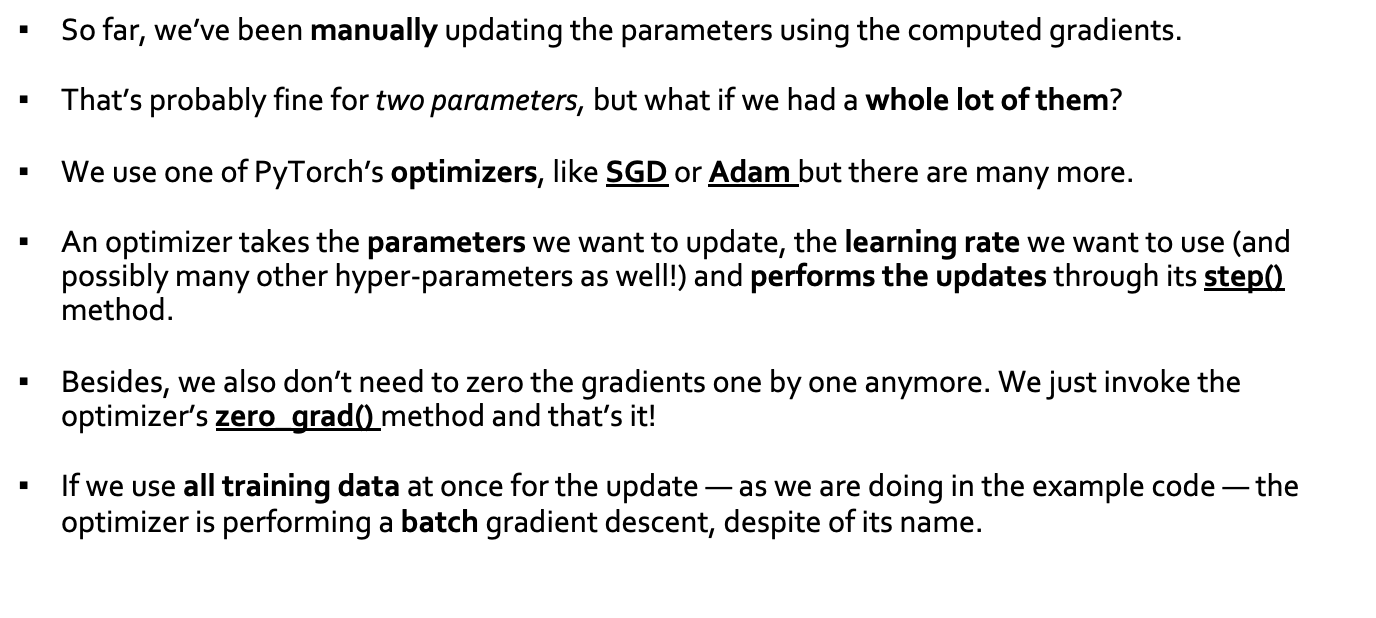

In [6]:
# Defines a SGD optimizer to update the parameters

import torch.optim as optim
#from torch.optim import SGD

optimizer = optim.SGD([w0, w1], lr=lr)

for epoch in range(n_epochs):
    yhat = w0 + w1 * x_train_tensor
    error = y_train_tensor - yhat
    loss = (error ** 2).mean()

    loss.backward()    
    
    optimizer.step()
    
    # No more telling PyTorch to let gradients go!
    # w0.grad.zero_()
    # w1.grad.zero_()
    optimizer.zero_grad()
    
print(w0, w1)

tensor([1.0235], requires_grad=True) tensor([1.9690], requires_grad=True)


## Loss function implementation ##

In [7]:
# Loss function implementation and loss computation

import torch.nn as nn

# Inititlaize parameters again
w0 = torch.randn(1, requires_grad=True, dtype=torch.float, device=device)
w1 = torch.randn(1, requires_grad=True, dtype=torch.float, device=device)

lr = 1e-1
n_epochs = 1000

# Defines a MSE loss function
loss_fn = nn.MSELoss(reduction='mean')

optimizer = optim.SGD([w0,w1], lr=lr)

for epoch in range(n_epochs):
    yhat = w0 + w1 * x_train_tensor
    
    # No more manual loss!
    # error = y_tensor - yhat
    # loss = (error ** 2).mean()
    loss = loss_fn(y_train_tensor, yhat)

    loss.backward()    
    optimizer.step()
    optimizer.zero_grad()
    
print(w0,w1)

tensor([1.0235], requires_grad=True) tensor([1.9690], requires_grad=True)


## Creating a Model ##

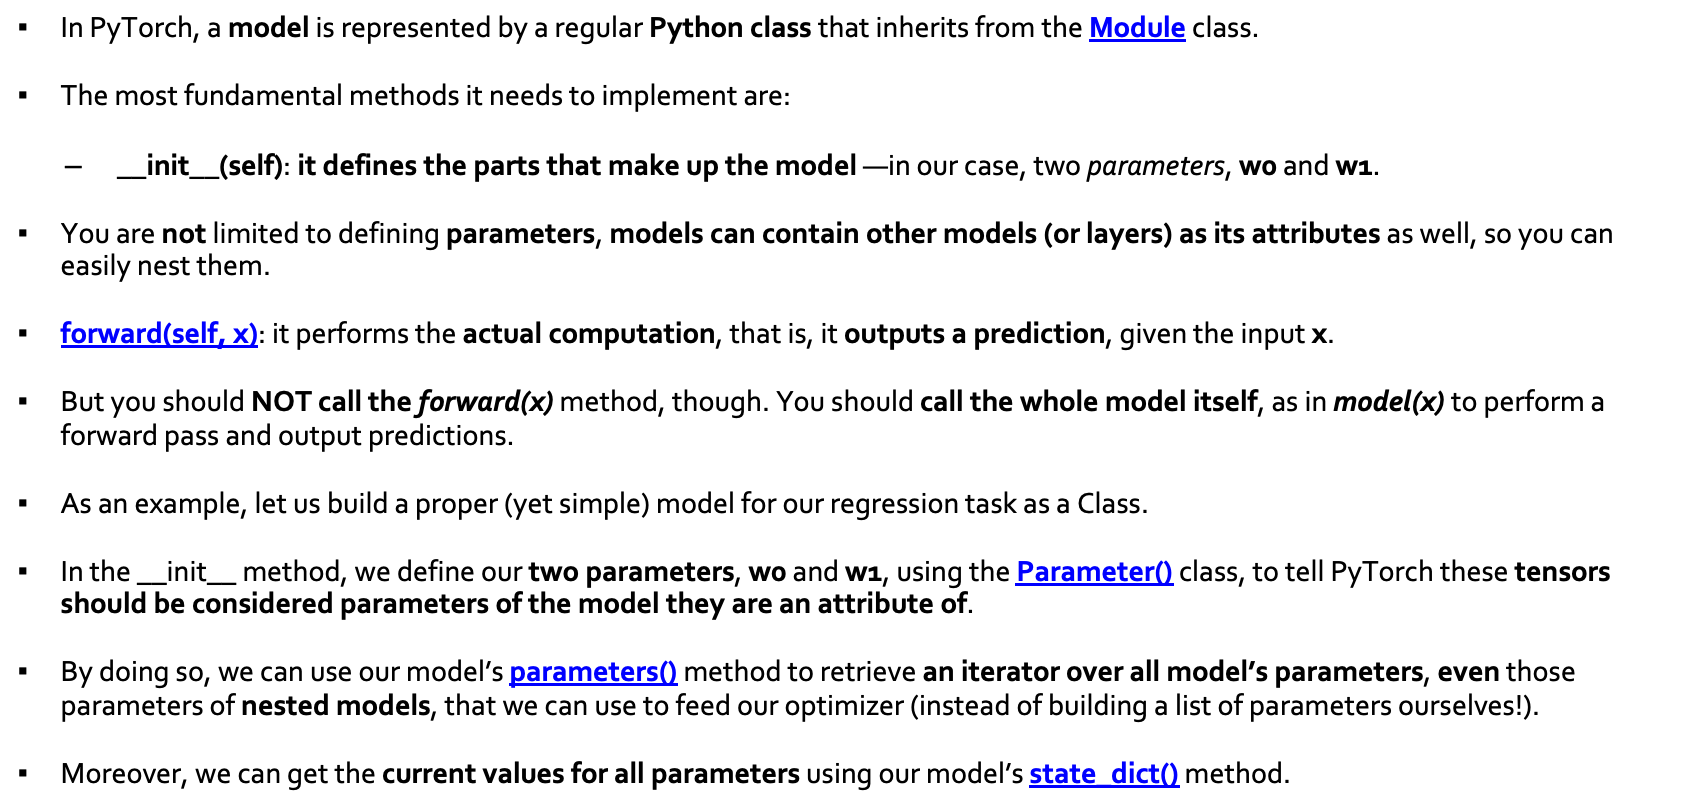


In [8]:
# How about simplifying everything by creating a model as a class
# We can inherit the parent class from PyTorch module call nn for neural networks

class ManualLinearRegression(nn.Module):
    def __init__(self):
        super().__init__()
        # To make "a" and "b" real parameters of the model, we need to wrap them with nn.Parameter
        self.w0 = nn.Parameter(torch.randn(1, requires_grad=True, dtype=torch.float))
        self.w1 = nn.Parameter(torch.randn(1, requires_grad=True, dtype=torch.float))
        
    def forward(self, x):
        # Computes the outputs / predictions
        return self.w0 + self.w1 * x

In [9]:
# Now we can create a model object and send it at once to the device
model = ManualLinearRegression().to(device)

# We can also inspect its parameters or weights using its state_dict method
print(f"Parameters or weights of our model before training:\n{model.state_dict()}")

# Set learning rate and number of epochs
lr = 1e-3
n_epochs = 25000

loss_fn = nn.MSELoss(reduction='mean')
optimizer = optim.SGD(model.parameters(), lr=lr)

for epoch in range(n_epochs):
    
    model.train()
    # What is this?!?
    # In PyTorch, models have a train() method which, 
    # does NOT perform a training step. Its only purpose is to set the model to training mode. 
    # When set in training mode it does gradient descent on any values which "require grad" during backpropogation
    

    # No more manual prediction! (yhat = a + b * x_tensor)
    # We use the model to predict
    yhat = model(x_train_tensor)
    
    # Compute loss using loss function
    loss = loss_fn(y_train_tensor, yhat)
    
    # Back propogate with backward()
    loss.backward()    
    optimizer.step()
    optimizer.zero_grad()
    
print(f"\nParameters or weights of our model after training:\n{model.state_dict()}")

Parameters or weights of our model before training:
OrderedDict([('w0', tensor([2.2082])), ('w1', tensor([-0.6380]))])

Parameters or weights of our model after training:
OrderedDict([('w0', tensor([1.0533])), ('w1', tensor([1.9107]))])


## Complete Model using all PyTorch classes, functions and operators ##

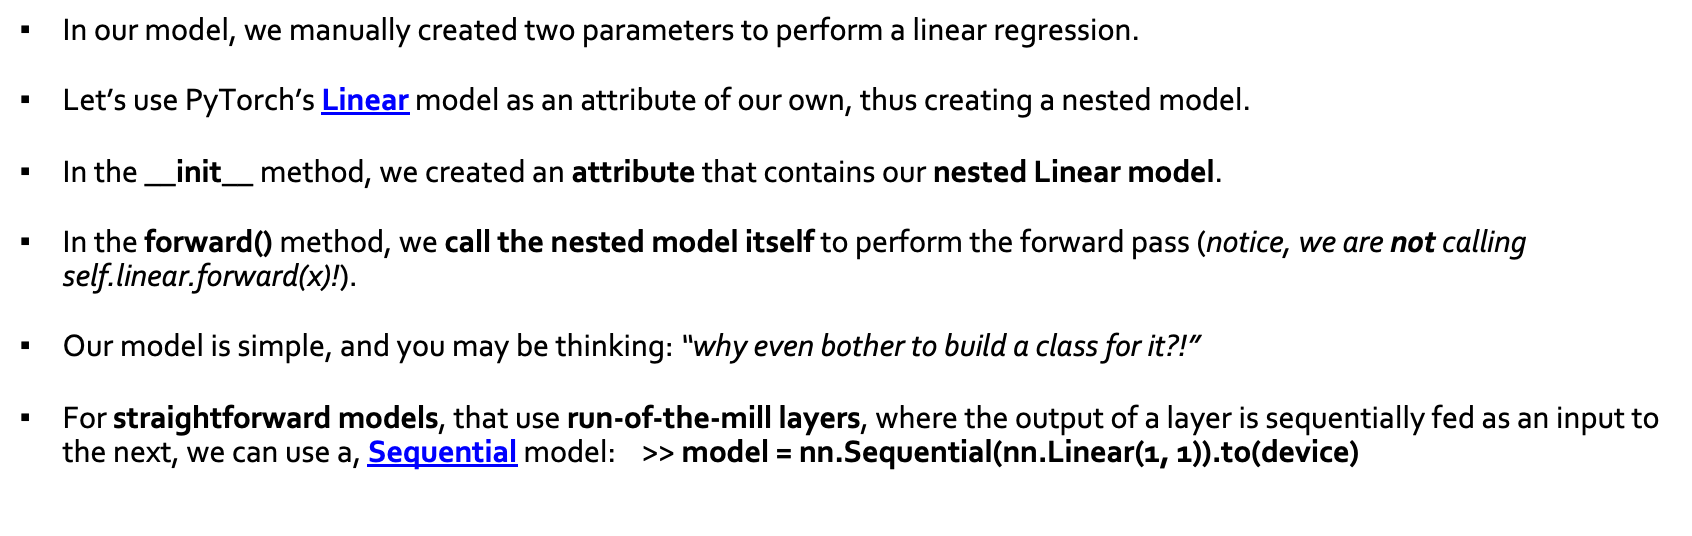

In [10]:
# Finally - Everything with PyTorch classes, functions and operators

class LayerLinearRegression(nn.Module):
    def __init__(self):
        super().__init__()
        # Instead of our custom parameters, we use a Linear layer with single input and single output
        self.linear = nn.Linear(1, 1)
                
    def forward(self, x):
        # Now it only takes a call to the layer to make predictions
        x = self.Linear(x)
        return x

## What Next? ##

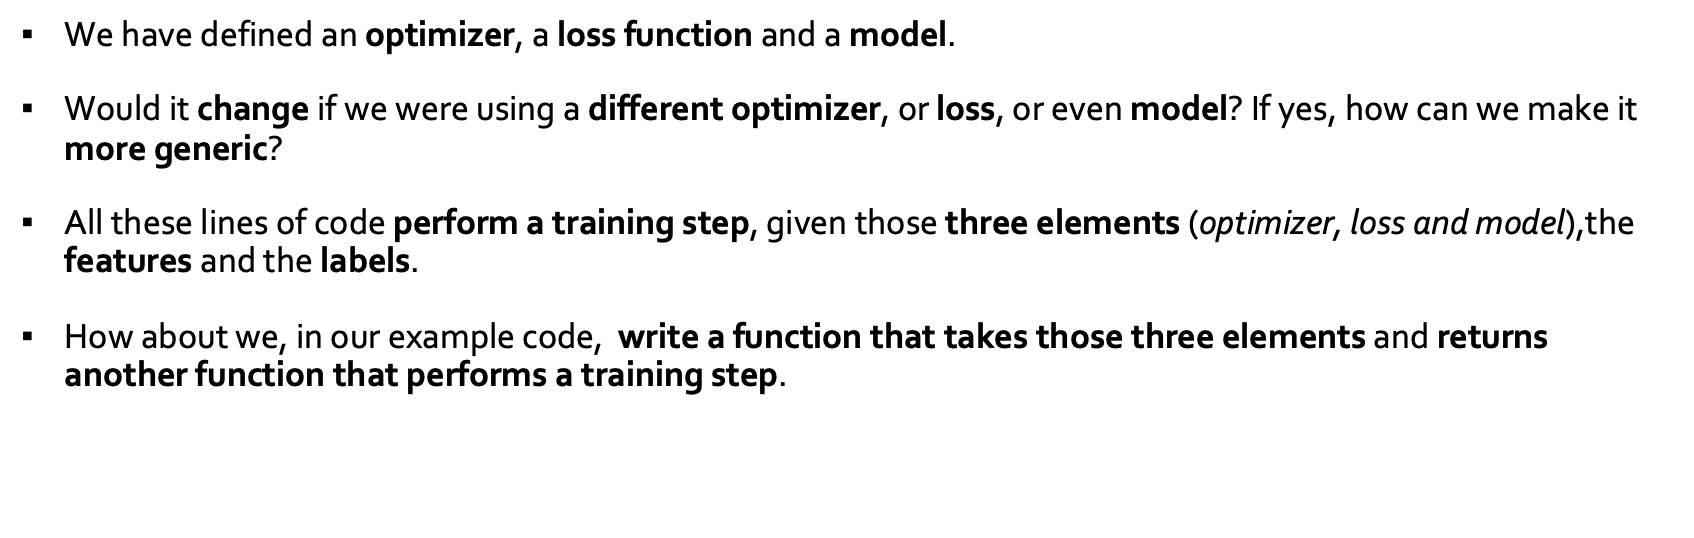

In [12]:
# Train step

def make_train_step(model, loss_fn, optimizer):
    
    # Builds function that performs one step in the train loop
    def train_step(x, y):
        
        # Sets model to TRAIN mode
        model.train()
        # Makes predictions
        yhat = model(x)
        # Computes loss
        loss = loss_fn(y, yhat)
        # Computes gradients
        loss.backward()
        # Updates parameters and zeroes gradients
        optimizer.step()
        optimizer.zero_grad()
        # Returns the loss
        return loss.item()
    
    # Returns the function that will be called inside the train loop
    return train_step


In [13]:
# Creates the train_step function for our model, loss function and optimizer
train_step = make_train_step(model, loss_fn, optimizer)

# A list to store losses per rpoch
losses = []

# For each epoch...
for epoch in range(n_epochs):
    # Performs one train step and returns the corresponding loss
    loss = train_step(x_train_tensor, y_train_tensor)
    
    losses.append(loss)
    
# Checks model's parameters
print(f"Final optimal parameters or eweights of our model:\n{model.state_dict()}")

Final optimal parameters or eweights of our model:
OrderedDict([('w0', tensor([1.0243])), ('w1', tensor([1.9675]))])


### Line of Regression

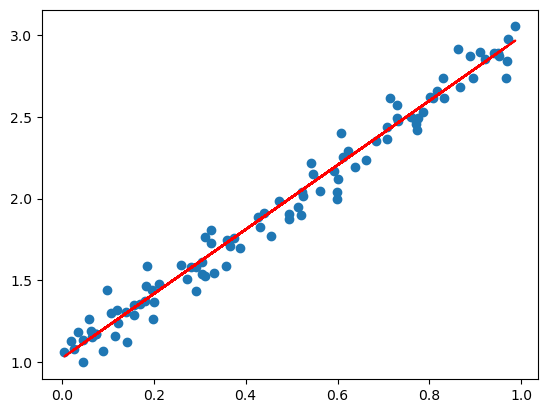

In [14]:
# Plot line of regression
# Remember that we never converted 'x' to a tensor (we only converted x_train to a tensor) and so we need to.
# To plot using matplotlib we need to make them np arrays again using the "detach" function

prediction_on_x = model(torch.from_numpy(x).float().to(device))

plt.scatter(x,y)
plt.plot(x,prediction_on_x.detach().numpy(),c='r')
plt.show()

### Loss curve

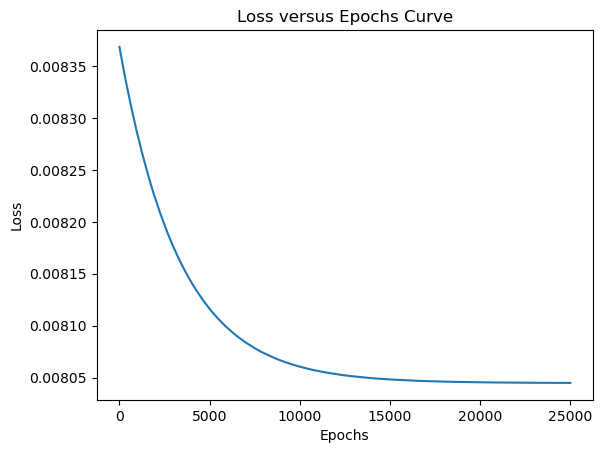

In [15]:
plt.plot(losses)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss versus Epochs Curve')
plt.show()